<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/06_Transfer_Learning_Part3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 25 08:03:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with TensorFlow - Scaling Up 
We've seen the power of transfer learning feature extraction and fine-tuning now it's time to scale up to all of the classes in Food101 (101 classes). 

Our goal is to beat original Food101 paper with 10% of the training data, leveraging the power of the transfer learning. Our baseline is to beat 50.76% accuracy across 101 classes.

### Thing's to cover 
- Downloading $ preparing 10% of all Food101 classes (7500+ training images). 
- Training a **transfer learning feature extraction** model. 
- Fine-tuning our feature extraction model(👁 Food Vision mini) to beat the original Food101 paper with only 10% of the data. 
- Evaluating Food Vision mini's predictions. 
  - Finding the most wrong prediction (on the test data). 
- Making **predictions with the Food Vision mini on our custom images**.



## Creating Helper function 
In previous notebook, we've created a series of helper function to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-25 08:05:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-25 08:05:32 (86.8 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [3]:
# Import series of helper function for our notebook 
from helper_functions import  create_tensorboard_callback , unzip_data , plot_loss_curves , compare_historys , walk_through_dir

## 101 Food Classes: workking with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it. 

The data we're downloading comes from original Food101 dataset but has been preprocessed using the `image_data_modification.ipynb`

In [6]:
# Getting the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2021-03-25 08:12:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.240, 172.217.164.176, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   162MB/s    in 7.2s    

2021-03-25 08:12:29 (216 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
# How many images classes are there 
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_

In [10]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224 , 224)

# Loading in the data
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                                image_size = IMG_SIZE , 
                                                                                batch_size = 32 , 
                                                                                label_mode = 'categorical') 

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                label_mode = 'categorical' , 
                                                                image_size = IMG_SIZE, 
                                                                shuffle = False) # don't shuffle data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
print('Hello World')

Hello World


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take: 
- Create a `ModelCheckpoint` callback.
- Create **data augmentation layer** to build data augmentation right into the model. 
- Build a headless (no top layers) Functional EfficientNet B0 backboned-model(we'll create our own output layer). 
- Compile our model 
- Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data to save epoch time). 

In [12]:
# Create checkpoint callback 
checkpoint_path = '101_food_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path , 
                                                         monitor = 'val_accuracy' ,  # stores higher accuracy
                                                         save_weights_only = True )

In [15]:
# Create data augmentation layer to incorporate it right into the model 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation 
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2) , 
  preprocessing.RandomZoom(0.2)
] , name = 'data_augmentation_layer')


In [17]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # backboned-model

# Freezing the base model (freeze all of the patterns)
base_model.trainable = False

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape = (224 , 224, 3) ,name = 'input_layer')
x = data_augmentation(inputs) # Augment images only happens during training 
x = base_model(x , training = False) # puts the base model in inference mode so weights which need to stay frozen, stays frozen
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool_2D_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names) , activation='softmax' , name = 'output_layer')(x)

# Packing into a model 
model = tf.keras.Model(inputs , outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [18]:
# Checking the summary of the model 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_2D_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
# Compile the model 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [21]:
# Fitting the model 
history_all_class_10_percent = model.fit(train_data_all_10_percent , 
                                         epochs = 5 , 
                                         validation_data = test_data , 
                                         validation_steps = int(0.25 * len(test_data)) , 
                                         callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 139s 431ms/step - loss: 3.9919 - accuracy: 0.1477 - val_loss: 2.6118 - val_accuracy: 0.4034
Epoch 2/5
237/237 [==============================] - 86s 362ms/step - loss: 2.4297 - accuracy: 0.4547 - val_loss: 2.2234 - val_accuracy: 0.4456
Epoch 3/5
237/237 [==============================] - 81s 340ms/step - loss: 2.0042 - accuracy: 0.5256 - val_loss: 2.0636 - val_accuracy: 0.4713
Epoch 4/5
237/237 [==============================] - 75s 315ms/step - loss: 1.7518 - accuracy: 0.5805 - val_loss: 1.9721 - val_accuracy: 0.4940
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.6124 - accuracy: 0.6122 - val_loss: 1.9401 - val_accuracy: 0.4872


In [22]:
# Let's evaluate on the whole test data 
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.7044 - accuracy: 0.5533


After we evaluated our model on the whole test set, we got a accuracy of **`55%`** and we beat the paper!!! 

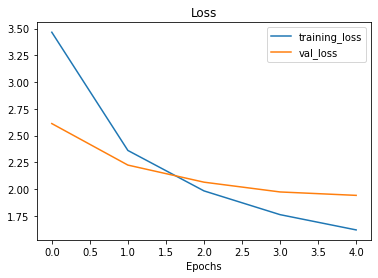

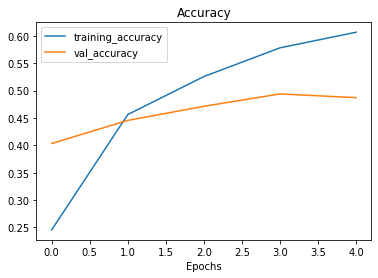

In [25]:
# Let's watch the loss curves 
plot_loss_curves(history_all_class_10_percent)

> **Question** What do these curves suggest? 
Ideally, the two curves should be similar to each other if not.. Overfitting!

They should be close to eachother, it seems if we are gonna train for more epochs our results might get worse as we train for more epochs. 

## Fine-tuning 

In [26]:
# Unfreeze all of the layers in the base model
base_model.trainable = True 

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [27]:
# Compile the model (it's best practice to lower the learning rate when fine-tuning)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , # learning rate lowered
              metrics = ['accuracy'])

In [30]:
# What layers in the model are trainable 
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pool_2D_layer True
output_layer True


In [31]:
# Check which layers are trainable in our base_model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [35]:
# Fitting our model and fine_tuning it
initial_epochs = 5 
fine_tune_epochs = initial_epochs + 5
history_all_classes_fine_tune_10_percent = model.fit(train_data_all_10_percent , 
                                                     epochs = fine_tune_epochs , 
                                                     validation_data = test_data , 
                                                     validation_steps = int(0.15 * len(test_data)) , 
                                                     initial_epoch = history_all_class_10_percent.epoch[-1] )

Epoch 5/10
237/237 [==============================] - 70s 273ms/step - loss: 1.4177 - accuracy: 0.6386 - val_loss: 1.9245 - val_accuracy: 0.4995
Epoch 6/10
237/237 [==============================] - 61s 256ms/step - loss: 1.2421 - accuracy: 0.6779 - val_loss: 1.8894 - val_accuracy: 0.5048
Epoch 7/10
237/237 [==============================] - 62s 261ms/step - loss: 1.1772 - accuracy: 0.6901 - val_loss: 1.8704 - val_accuracy: 0.5130
Epoch 8/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0814 - accuracy: 0.7181 - val_loss: 1.8796 - val_accuracy: 0.5167
Epoch 9/10
237/237 [==============================] - 58s 244ms/step - loss: 1.0292 - accuracy: 0.7267 - val_loss: 1.8775 - val_accuracy: 0.5175
Epoch 10/10
237/237 [==============================] - 55s 231ms/step - loss: 0.9768 - accuracy: 0.7418 - val_loss: 1.8605 - val_accuracy: 0.5204


In [33]:
history_all_class_10_percent.epoch[-1]

4

In [36]:
# Evaluate on the whole test data 
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 101s 127ms/step - loss: 1.5948 - accuracy: 0.5780


In [37]:
# Results for feature extraction 
feature_extraction_results

[1.7043648958206177, 0.5532673001289368]

Hmm, there isn't a much difference. After fine-tuning the accuracy increased only by 2%. 

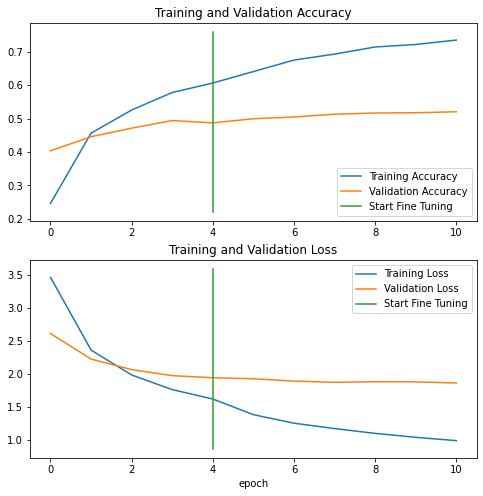

In [38]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(history_all_class_10_percent , 
                 history_all_classes_fine_tune_10_percent , 
                 initial_epochs = 5)

Observing the plot, it seems our model is overfitting on the training data. 